In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('/Users/burakfindikli/Documents/repos/ML_Analiz/data/2018-2019_tsl.csv',index_col = False)
df2=pd.read_csv('/Users/burakfindikli/Documents/repos/ML_Analiz/data/2018-2019_tsl.csv',index_col = False)

In [5]:
#  2017-2018 ile 2018-2019 sezonunun Maçlarını birleştirdim
df3=pd.concat([df, df2], ignore_index=True)


In [6]:
#Maçı ev sahibi kazandıysa 1 beraberlik olduysa 0 deplasman takımı kazandıysa 2 diye kodladım.
df3["kazanan_dep"]=df3.ev_sonuc < df3.dep_sonuc
df3.kazanan_dep = df3.kazanan_dep.astype(int)*2

df3["kazanan_ev"] = df3.ev_sonuc > df3.dep_sonuc
df3.kazanan_ev = df3.kazanan_ev.astype(int)

df3["kazanan_berabere"] = df3.ev_sonuc == df3.dep_sonuc
df3.kazanan_berabere = df3.kazanan_berabere.astype(int)*0

df3["sonuc"]=df3.kazanan_dep+df3.kazanan_ev+df3.kazanan_berabere
df3=df3.drop(['kazanan_dep', 'kazanan_ev','kazanan_berabere','ev_gol','dep_gol'], axis=1)
del(df,df2)

In [7]:
#bu değişkenlerde % ve , var temizleme yapmam lazım
col=['ev_topla_oynama','ev_ikili_mucadele_kazanma','ev_hava_topu','dep_topla_oynama','dep_ikili_mucadele_kazanma','dep_hava_topu','ev_pas_isabet','ev_rakip_yari_sahada_pas_isabeti','ev_orta_istabeti','dep_pas_isabet','dep_rakip_yari_sahada_pas_isabeti','dep_orta_istabeti','ev_sut_isabeti','dep_sut_isabeti','ev_top_kapma_basarisi','dep_top_kapma_basarisi']

In [8]:
# col değişkenindeki % , gibi karakterleri replace ettim
k=0
while k < df3[col].shape[1]:
    df3[col[k]] = df3[col[k]].str.replace(",",".")
    df3[col[k]] = df3[col[k]].str.replace("%","")
    k+=1

In [9]:
#object olan veri tiplerini floata çevirdim
df3[col]=df3[col].astype(float)

In [10]:
drop_value = ['ev_takim', 'dep_takim', 'ev_sonuc', 'dep_sonuc', ]
df3=df3.drop(drop_value,axis=1)

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
#bağımlı bağımsız değişkenlerimi ayırdım 
#bağımlı değişken sonuc(1=Evsahibi kazanır 0=Beraberlik 2=Deplasman kazanır)
x = df3.iloc[:,:-1]
y = df3.sonuc
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_scaled = stdsc.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=101)

In [13]:
#Gerekli kütüphaneleri kurdum
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

In [14]:
#modeli kurdum ve ne kadar sürede çalıstıgına baktım
start = time.process_time()
model = RandomForestClassifier().fit(X_train,y_train)
print(time.process_time()-start)

0.7750780000000006


In [15]:
#modeli tahmin ettim
preds = model.predict(X_test)

In [16]:
#confision matrisi
print(confusion_matrix(y_test,preds))

print(classification_report(y_test,preds))

[[109  10   2]
 [  6 208   4]
 [  4  12 121]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       121
           1       0.90      0.95      0.93       218
           2       0.95      0.88      0.92       137

    accuracy                           0.92       476
   macro avg       0.92      0.91      0.92       476
weighted avg       0.92      0.92      0.92       476



In [17]:
#değişkenlerin modele olan katkılarına baktım

model.feature_importances_

array([0.02026711, 0.01983823, 0.02114708, 0.01641249, 0.01044804,
       0.01283821, 0.01898742, 0.02132985, 0.02121081, 0.01828735,
       0.01179506, 0.01242377, 0.02133053, 0.01708835, 0.02383511,
       0.02718208, 0.0325434 , 0.02050243, 0.02400625, 0.02394929,
       0.02664687, 0.02449   , 0.02148511, 0.02144452, 0.0167233 ,
       0.03600805, 0.01398914, 0.01457806, 0.02502467, 0.05391744,
       0.01708706, 0.03333673, 0.00941254, 0.01430948, 0.0255652 ,
       0.04232638, 0.01728274, 0.01807003, 0.03082172, 0.01820735,
       0.0202787 , 0.04351633, 0.01533258, 0.01096434, 0.00418838,
       0.0160646 , 0.009307  , 0.00419881])

In [18]:
feature_imp = pd.Series(model.feature_importances_, index = x.columns)

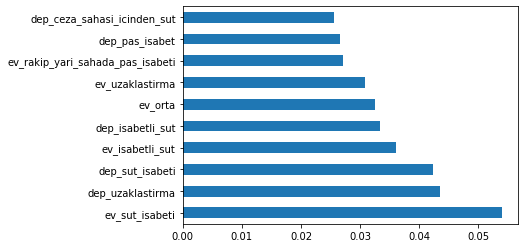

In [19]:
#degiskenelrin ilk 10 taneisini grafikledim
feature_imp.nlargest(10).plot(kind='barh')

In [20]:
best_feature = feature_imp.nlargest(6).index.to_list()

In [21]:
x_reduced = x[best_feature]

In [22]:
xr_scaled = StandardScaler().fit_transform(x_reduced)

In [23]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(xr_scaled,y,test_size=0.2,random_state=101)

In [24]:
#en önemli 6 değişken ile modelimi tahmin etmeye çalıstım burada bütün değişkenleri kullanmak zaman açısından çok masraflı olabiliyor bu yüzden zamandan kazanarak kabuledilebilir bir accuracy kayıbıyla işleri hızlandırabiliriz. gördüğümüz gibi 0.20 zamandan kar edildi. accuracyden kaybımız ise 0.02 oldu.
start = time.process_time()
rmodel = RandomForestClassifier().fit(Xr_train,yr_train)
print(time.process_time()-start)

0.43956900000000054


In [25]:
rpred = rmodel.predict(Xr_test)
print(confusion_matrix(yr_test,rpred))
print(classification_report(yr_test,rpred))

[[107  10   4]
 [  8 204   6]
 [  8  12 117]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       121
           1       0.90      0.94      0.92       218
           2       0.92      0.85      0.89       137

    accuracy                           0.90       476
   macro avg       0.90      0.89      0.89       476
weighted avg       0.90      0.90      0.90       476



In [29]:
rf_params = {"max_depth": [5,8,10],
             "max_features": [2,5,10],
             "n_estimators": [200,500,1000,2000],
             "min_samples_split": [2,10,80,100]}

In [28]:
rf_cv_model = GridSearchCV(rmodel,rf_params,cv=10,n_jobs=-1,verbose=2 ).fit(Xr_train,yr_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Invalid parameter min_sample_split for estimator RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.